# Weather Data 
From ALLL Available sources PPG, NOAA Tula, ASCC station, and my stations

In [0]:
Introduction: 
    - data gaps are a prevalent issue in weather and environmental modeling 
    - currrent methods for filling data gaps include   (need to learn and apply these methods) 
    - issues with these current methods
    - why machiene learning is cool and useful for this (review of current literature) 
    - what We did
    
Methods: 
    - Data collection instruments, and locations, data procuremtns
    - Maybe should try and do the RNN for filling in PPG data gaps, then the other network for comparitive filling

Notes: 
    for now use daily values. can sub to hourly later maybe if need
    
    # Old method for ppg data based on static datasets,, us the API instead  (Eventiually) 
(note no other NOAA stations are worth their salt) 
    

In [1]:
# Clone the entire repo.
!git clone -l -s git://github.com/cshuler/Machine_Learning_Magic_gap_filling
%cd Machine_Learning_Magic_gap_filling/Scripts
!ls



fatal: destination path 'Machine_Learning_Magic_gap_filling' already exists and is not an empty directory.
/content/Machine_Learning_Magic_gap_filling/Scripts
baseflow_separator.py	   __pycache__
getRainfallData.py	   Stream_gap_fill_validation_FIND_Master.ipynb
key.py			   testmodel_random_callback_save.h5
Old			   Weather_gap_fill2.ipynb
PPG_gap_fill_master.ipynb  workspace


In [2]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

%matplotlib inline
#%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import io
import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import re

# import function from current working directory
from getRainfallData import getRainfallData

workspace = os.path.join('.', 'workspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)


pd.set_option('display.max_rows', 50)    
np.set_printoptions(suppress=True)

Using TensorFlow backend.


# Firstly, fill in PPG Airport Data completely
using static data files for now, can switch to an API later when desired to keep all data up to date, will take more work to program
from http://scacis.rcc-acis.org/ for daily data  and also from: https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:61705/detail for hourly data


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


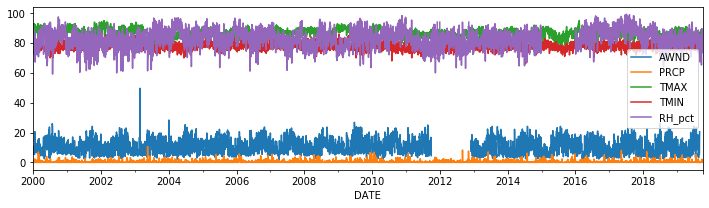

In [3]:
path_PPG_data = os.path.join("..", "Data", 'External_weather_data', 'PPG', "daily")                # open dataset
PPG = pd.read_csv(os.path.join(path_PPG_data, 'PPG-2000-oct2-19-daily.csv'), usecols = [2, 5, 13, 18, 19]) #  ,21])  will give wind directions
PPG['DATE'] = pd.to_datetime(PPG['DATE'], errors='coerce')
PPG = PPG.set_index('DATE')

# Now Hourly Airport Data  (junkshow) for needed only for RH data, not in the daily file for some reason, 
path_PPG_data_RH = os.path.join("..", "Data", 'External_weather_data', 'PPG', "hourly")                # open dataset

a = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG_2010-2019(oct)-hourly.csv'), usecols = [1,2,3, 48])  # cut out rando columns
b = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG-2000-2009-hourly.csv'), usecols = [1,2,3, 48])       # cut out rando columns
c = pd.concat([b, a])                                                                                    # merge em together

c = c[c['REPORT_TYPE'] == 'FM-15']                                       # apparently the hourly data we want is codes as FM-15 Data
c['DATE'] = pd.to_datetime(c['DATE'], errors='coerce')                   # string date to real date
c['DATE'] = c['DATE'].dt.round('H')                                      # timestamps are in rando near hour times, round to the hour
c = c.set_index('DATE')
del c['REPORT_TYPE']
del c['SOURCE']
c = c.apply(pd.to_numeric, errors='coerce')                       # convert all columns of DataFrame to floats, turns any non-numerics to nan

#  resample to daily values 
PPG_RH_dat = c.resample('D').mean()      # resample the rain different than the other columns
PPG_RH_dat.rename(columns={'HourlyRelativeHumidity': 'RH_pct'}, inplace=True)      # rename column

PPG = PPG.join(PPG_RH_dat)                 #merge the datasets together

PPG.plot(figsize =(12,3))

# Define some functions

In [0]:
### This is used to Identify and label places where there are gaps in the data

def find_date_gaps(dataset_raw, Colinterest):

    a = dataset_raw[Colinterest].values  # Extract out relevant column from dataframe as array
    ## Now gap filling time: 
    # First: all of this is to go through each dataset and identify the start and the end of each gap. 

    m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

    gapstarts_L = []; gapends_L = []
    # this is if the series started late, i.e. the first gap is at the beginning
    if ss[0][0] != 0:     
        gapstart = 0
        gapstarts_L.append(gapstart)
        for m in ss:
            gapstart2 = m[1]
            gapstarts_L.append(gapstart2)
            gapends_L.append(m[0])
        del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

    # this is if the series starst at the beginning of the data period, first gap is in the middle 
    for m in ss:
        gapstarts_L.append(m[1])
        gapends_L.append(m[0])
    del gapstarts_L[-1]
    del gapends_L[0]

    gapstarts_Dates = []; gapends_Dates = []
    for h in gapstarts_L:
        date5 = dataset_raw.index[h]
        gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
    for h in gapends_L:
        date5 = dataset_raw.index[h]
        gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps
           
    # list the 
    for idx, val in enumerate(gapstarts_Dates):
        length = gapends_Dates[idx] -gapstarts_Dates[idx]
        print("gap {} is {} from {} to {}".format(idx, length, gapstarts_Dates[idx], gapends_Dates[idx] ))
    
    return gapstarts_Dates, gapends_Dates

In [0]:
# this is used to ID gaps and Autofill less than one week long ones

def ID_n_Fill_gaps(dataset_raw):
    
    dataset_cleanish = dataset_raw.copy()    # create output dataset to map fixed data into
    
    for col in dataset_raw.columns: 
        print('...................................................................................')
        print("{} gaps are".format(col))
        
        # ID gaps
        gapstarts_Dates, gapends_Dates =  find_date_gaps(dataset_raw, col)
        
        # Now fill gaps of one day by using average of yesterday's and tomorrow's values
        for idx, val in enumerate(gapstarts_Dates):
            strt = gapstarts_Dates[idx]                                             # note this is the first day with missing data, if only one this is the missing day
            ends = gapends_Dates[idx]                                               # this is the day where there is data again after a gap ( I think) 
            
            if ends - strt < pd.Timedelta('7 day'):                                # if the gap is 1 day long
                beforepoint = dataset_raw[col].loc[strt-pd.Timedelta('7 day')]      # This is the day before the one with the issing data 
                afterpoint = dataset_raw[col].loc[ends]                             # this is the day where there is data again after a gap ( I think) 
                avepoint = np.mean((beforepoint,afterpoint))                        # average of the adjacient values
                dataset_raw[col].loc[strt:ends] = avepoint                       # FILL the GAP with the ave value

        dataset_cleanish[col] = dataset_raw[col]
    
    return dataset_cleanish

In [0]:
# this is the creation of the DLNN model as a function
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [7]:
# implement the ID and fill gaps to take out any small gaps cuz they are annoying.
dataset_raw = PPG.copy()
dataset_cleanish = ID_n_Fill_gaps(dataset_raw)

...................................................................................
AWND gaps are
gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
gap 1 is 1 days 00:00:00 from 2015-02-10 00:00:00 to 2015-02-11 00:00:00
...................................................................................
PRCP gaps are
gap 0 is 1 days 00:00:00 from 2012-07-31 00:00:00 to 2012-08-01 00:00:00
gap 1 is 1 days 00:00:00 from 2012-10-31 00:00:00 to 2012-11-01 00:00:00
gap 2 is 1 days 00:00:00 from 2019-09-01 00:00:00 to 2019-09-02 00:00:00
...................................................................................
TMAX gaps are
gap 0 is 1 days 00:00:00 from 2019-09-30 00:00:00 to 2019-10-01 00:00:00
...................................................................................
TMIN gaps are
gap 0 is 1 days 00:00:00 from 2019-09-06 00:00:00 to 2019-09-07 00:00:00
...................................................................................
RH_pct gaps

# First order calibration and validation 
### looking at how well the network matches the training data, this is mainly to assess model performance and uncertainty
note: need to manually definine columns to work with, 

In [57]:
# this might be automated further in the future but need to find a period where there are no gaps, for now look manually at the potput of this:

ID_n_Fill_gaps(dataset_cleanish)          # just calling this print off a list of the gaps, doesnt do anything since there are no 1 day gaps left. 

""" looks like data is solid from  "2000-01-01"   to "2011-9-30"  """

unbroken_data = dataset_cleanish.loc[:"2011-9-30"]
#unbroken_data.plot()

# double check All is good
print("There are missing values in our train data = {}".format(unbroken_data.isnull().values.any()))



...................................................................................
AWND gaps are
gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
...................................................................................
PRCP gaps are
...................................................................................
TMAX gaps are
...................................................................................
TMIN gaps are
...................................................................................
RH_pct gaps are
gap 0 is 365 days 00:00:00 from 2015-01-01 00:00:00 to 2016-01-01 00:00:00
There are missing values in our train data = False


In [0]:
TRAIN_SPLIT = int(len(unbroken_data)*.80)     # train on say 2/3 of the data validate on the rest
# split data for train and validation
train_data = unbroken_data.iloc[:TRAIN_SPLIT]
val_data = unbroken_data.iloc[TRAIN_SPLIT:]


# determine which column to work with
x_cols = ['AWND', 'PRCP', 'TMIN', 'TMAX']
y_col = 'RH_pct'


# set up the training datasets
X_train = train_data[x_cols].values  
# scale the x component of the training data
X_train_scaler = StandardScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)

y_train = train_data[y_col].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
y_train = y_train.reshape(-1, 1)
y_train_scaler = StandardScaler().fit(y_train)
y_train = y_train_scaler.transform(y_train)


# set up the validation datasets
X_val = val_data[x_cols].values  
# scale the x component of the training data
X_val_scaler = StandardScaler().fit(X_val)
X_val = X_val_scaler.transform(X_val)

y_val = val_data[y_col].values
y_val = y_val.reshape(-1, 1)
y_val_scaler = StandardScaler().fit(y_val)
y_val = y_val_scaler.transform(y_val)

In [59]:
input_shape = len(x_cols)
input_shape

4

In [0]:
# this is the creation of the DLNN model as a function
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    return model

In [106]:

#define the DL model and its parameters to use for other models creates object named model in memory

hidden_layer_sizes =  [12, 80, 80]
input_shape = len(x_cols)
activation     = 'relu'
optimizer      = 'sgd'

model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

# train the network
# Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=150, mode='min', min_delta=0.001),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit(X_train, y_train, epochs=2000,verbose=1, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

## load the best saved model based on validation loss
model = load_model(checkpoint_path)
scores = model.evaluate(X_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 12)                60        
_________________________________________________________________
dense_162 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_163 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 81        
Total params: 7,661
Trainable params: 7,661
Non-trainable params: 0
_________________________________________________________________
Train on 3432 samples, validate on 859 samples
Epoch 1/2000
3432/3432 [==============================] - 4s 1ms/step - loss: 0.7395 - mean_squared_error: 0.8877 - val_loss: 0.7277 - val_mean_squared_error: 0.8253
Epoch 2/2000
3432/3432 [============

### Examine the results

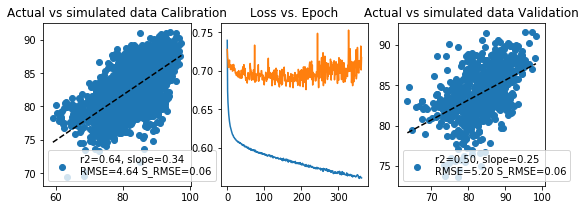

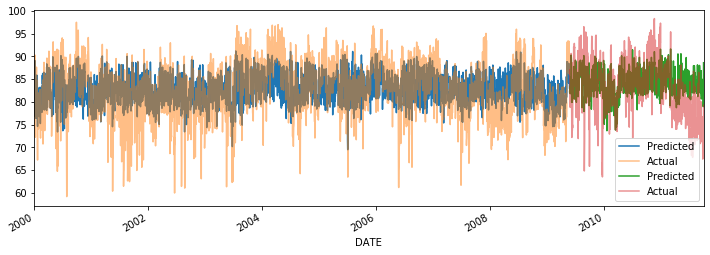

In [107]:
# run the training dataset back through the netowrk to show how well it can match its traing values over calibration data (comp vs obs)    # this is a first order 

#### All plots
fig2, ax = plt.subplots(1, 3, figsize=(9, 3))

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()

###### Plot losses
ax[1].set_title('Loss vs. Epoch')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()

##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')

### Compare to simply gap filling with the mean

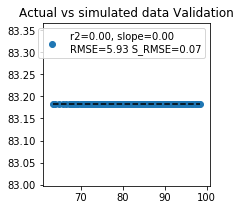

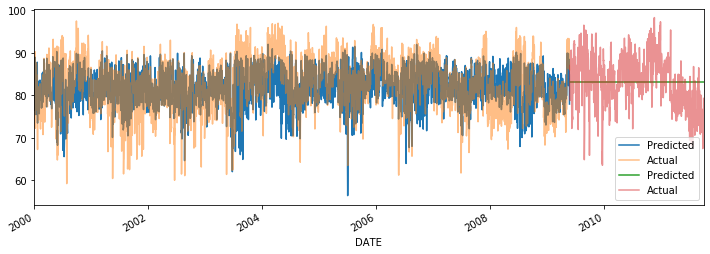

In [14]:
# run the training dataset back through the netowrk to show how well it can match its traing values over calibration data (comp vs obs)    # this is a first order 

#### All plots
fig2, ax = plt.subplots(1, 1, figsize=(3, 3))

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = np.full(np.shape(y_val), y_val.mean())
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax.plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax.scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax.set_title('Actual vs simulated data Validation')
ax.legend()

##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')

# Use the model, fill the gaps 
even though the model is un-ideal at the moment....
On issue to fix someday is that the absolute magnitudes of the data don't get quite up to par (the slope is under predicted...)

In [15]:
# Set up the gap filling by definging datasets and IDing the series needeing filling.

magic_data = dataset_cleanish.copy()
all_cols = list(magic_data.columns)
train_data_all = unbroken_data

# this bit makes a list of the variable that need some filling. (1 or > gaps) 
broken_vars = []
for var in all_cols:
    wha = find_date_gaps(dataset_cleanish, var)
    
    if wha[0]:                   # this means if the gap start lists are not empty
        broken_vars.append(var)  # make the list of broken variables

gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
gap 0 is 365 days 00:00:00 from 2015-01-01 00:00:00 to 2016-01-01 00:00:00


### Monster loop to fill all the gaps!

note this doesn't work if there are overlapping gaps ( to get around an overlappig 5 day gap I had to extend the mean fill period to 7 days, not the best...


In [16]:
magic_data = dataset_cleanish.copy()
YScaler_dic = {}; XScaler_dic = {}

for i in broken_vars:
    x_cols = ['AWND', 'PRCP', 'TMAX', 'TMIN', 'RH_pct']
    x_cols.remove(i)                                     # remove the param of interest
    y_col = i

    # set up the training datasets
    X_train = train_data_all[x_cols].values  
    # scale the x component of the training data
    XScaler_dic[i] = StandardScaler().fit(X_train)
    X_train =  XScaler_dic[i].transform(X_train)
    y_train = train_data_all[y_col].values                 
    # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    YScaler_dic[i] = StandardScaler().fit(y_train)
    y_train = YScaler_dic[i].transform(y_train) 
    
# set up the DL network     
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

    
# train the network
    # Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
    checkpoint_path = os.path.join(os.getcwd(), 'testmodel_random_callback_save.h5')
    keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
                         ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

    # load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=1)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
# fill the gaps 
    Strt_gp, End_gp = find_date_gaps(magic_data, i)                         # define all the existing gaps
    
    for idx, val in enumerate(Strt_gp):                                     # for each gap
        X_fill = magic_data[x_cols].loc[Strt_gp[idx]:End_gp[idx]].values    # existing data in other columns 
        # scale the x component of the fill data
        X_fill =  XScaler_dic[i].transform(X_fill)                           # scale existing data in other columns  
        y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
        
        y_pred_fill = YScaler_dic[i].inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above (have to use dictionary of scalers to make sure each col is scaled right)

        # replace the gap with predicted data!
        magic_data['{}_filled'.format(i)] = magic_data[i]
        magic_data['{}_filled'.format(i)].loc[Strt_gp[idx]:End_gp[idx]] = np.squeeze(y_pred_fill)       
        
magic_data.plot(figsize = (12, 5), alpha = .7)
magic_data.to_csv(os.path.join(workspace, "Magic_gap_filled_PPG_data.csv"))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12)                60        
_________________________________________________________________
dense_6 (Dense)              (None, 80)                1040      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 81        
Total params: 7,661
Trainable params: 7,661
Non-trainable params: 0
_________________________________________________________________
4291/4291 [==============================] - 0s 31us/step
Score: loss of 0.8463730927364889; acc of 0.0%
gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
Model: "sequential_3"
________________________________________________

# Now load in other datasets  from other weather stations

### Pull UH-ASPA data off of my GitHub site
note, reflects most recent update of processed data, not raw data

In [18]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Wx_REPO/workspace/QA_All_merged.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16346953

#### get the data into memory

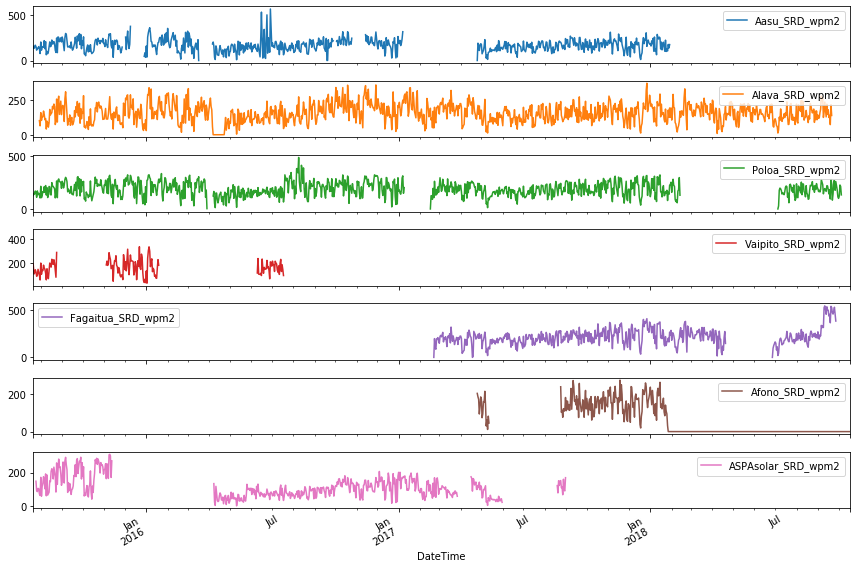

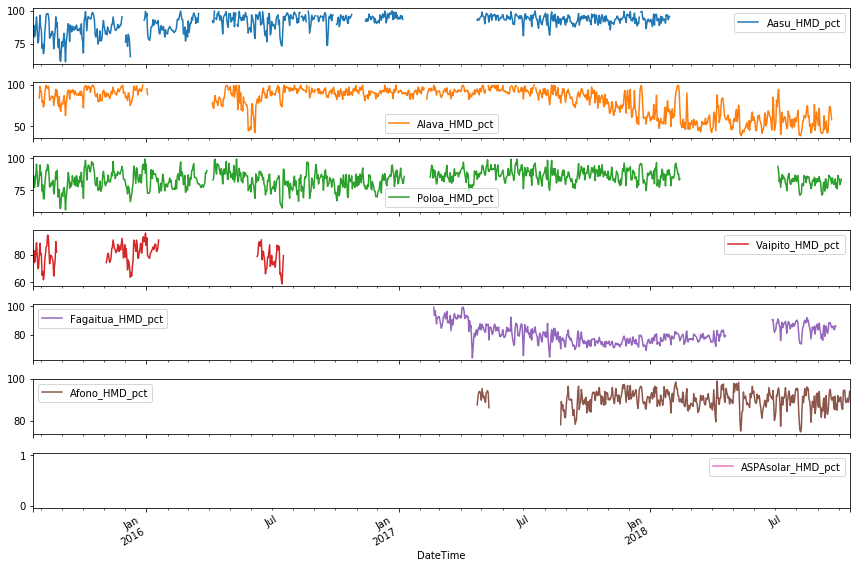

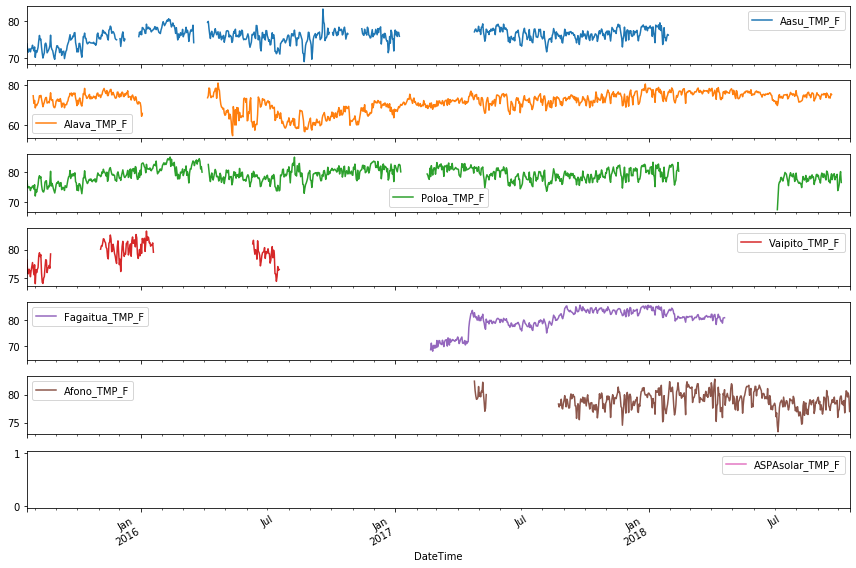

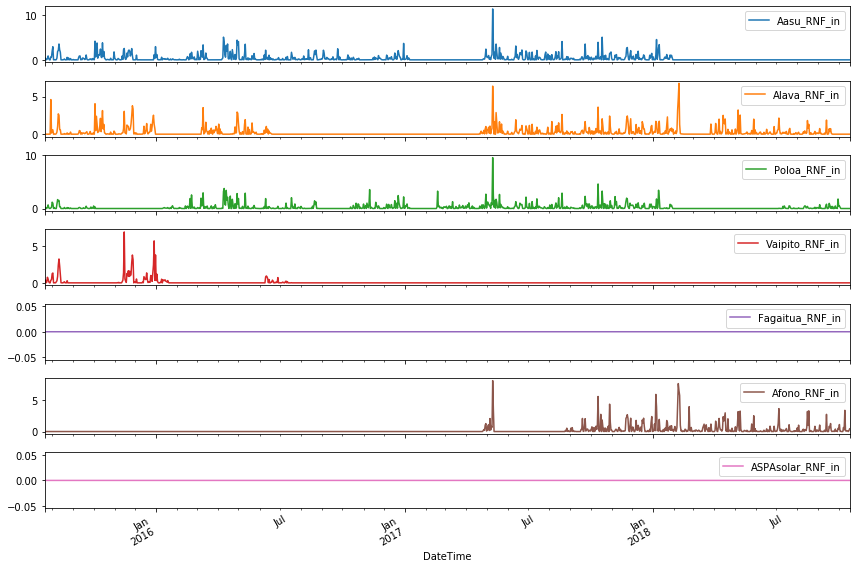

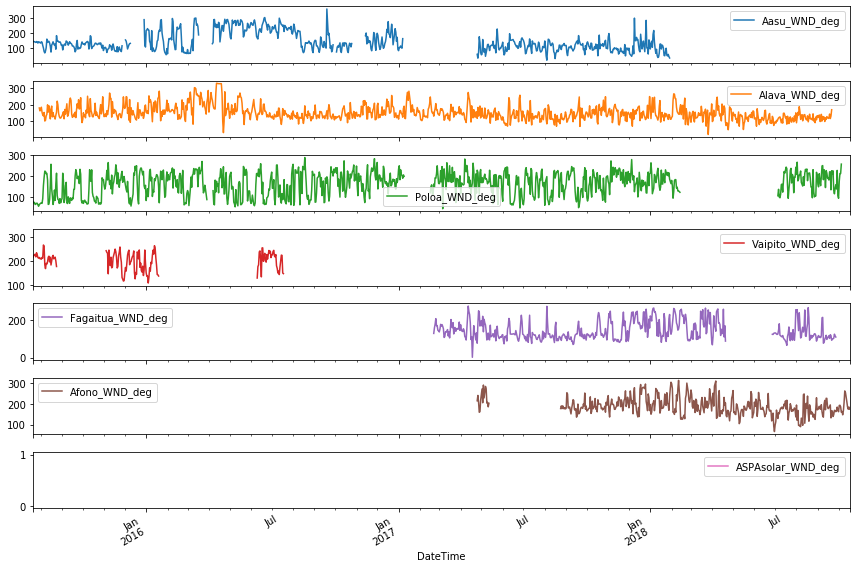

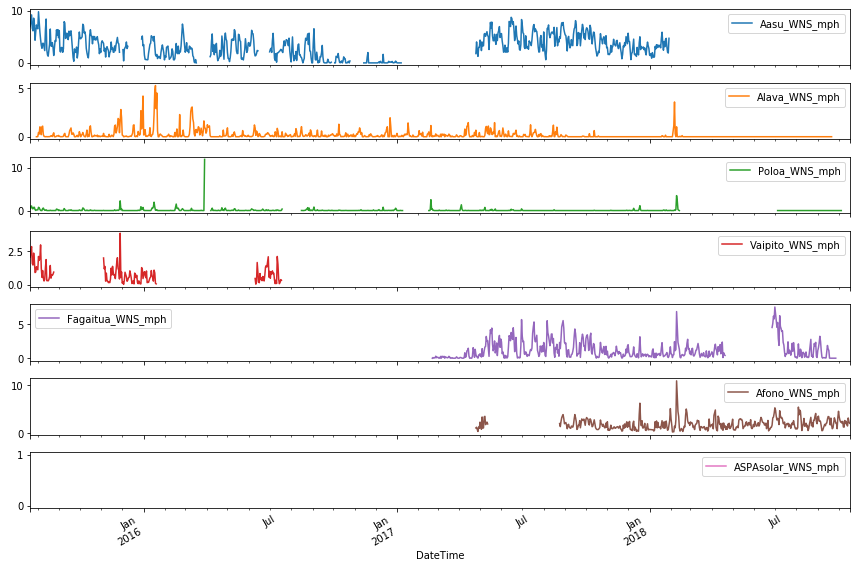

In [19]:
rawdata = pd.read_csv(save_to ,index_col=1,parse_dates=True)   # read in data
rawdata = rawdata.drop(rawdata.columns[0], axis=1)             # get rid of pesky index column

param_list =  ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

ASPA_param_dic = {}
for q in param_list: 
    r = re.compile(".*{}".format(q))  
    Col_list = list(filter(r.match, list(rawdata.columns)))
    tempframe = rawdata[Col_list]
    ASPA_param_dic[q] = tempframe
    
# resample the rainfall to hourly values using a sum method
ASPA_param_dic['RNF_in'] = ASPA_param_dic['RNF_in'].resample('D').sum()     # subsample the 15 min data into daily values
# resample all others to hourly values using a average method
ave_param_list = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'WND_deg', 'WNS_mph'] 
for i in ave_param_list:
    ASPA_param_dic[i] = ASPA_param_dic[i].resample('D').mean()     # subsample the 15 min data into daily values

# Exoloratory Plot  All the datasets 
for i in param_list: 
    ASPA_param_dic[i].plot(subplots=True, figsize=(12, 8))
    plt.tight_layout()
    plt.legend(loc='best')  

# Tula Data
From Tula weather station, pre-downloaded and living in a file folder, Tula site is: https://www.esrl.noaa.gov/gmd/obop/smo/

### careful, long run time

In [0]:
# processing Tula data into a single dataframe
path_Tula_data = os.path.join("..", "Data", 'External_weather_data', 'Tula', "Met")

trash_cols = ['SITE CODE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WND', 'WNS_mpsec', 'WND_STEADY', 'BAR_p', 'TMP_2m', 'TMP_10m', 'TMP_top', 'HMD', 'PRECIP_mm']
want_cols = ['Date', 'PRECIP_mm', 'HMD', 'TMP_2m', 'WND', 'WNS_mpsec']

files = os.listdir(path_Tula_data)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 
temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat

for i in files: 
    q = pd.read_csv(os.path.join(path_Tula_data, i), delim_whitespace=True, names=trash_cols, na_values=na_values) # open each file
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_data2 = temp_data[want_cols].set_index("Date") 

tula_data2['HMD'] = tula_data2['HMD'].apply(lambda x: 100 if x >99.9  else x) #Wtf?  Why are rel HMD values greater than 100%? fix this with some comon sense

# Now resampling data into neeed formats   this is set up for daily resampling 
tula_data2['Tmp_max'] = tula_data2['TMP_2m']                   # just make the columns get ready for resampling
tula_data2['Tmp_min'] = tula_data2['TMP_2m']                  # just make the columns get ready for resampling
tula_data2 = tula_data2.rename(columns={'TMP_2m': 'TMP_ave'})  # just make the columns get ready for resampling

tula_data_rn = tula_data2['PRECIP_mm'].resample('D').sum()      # resample the rain different than the other columns
tula_data_tmax = tula_data2['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
tula_data_tmin = tula_data2['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
tula_data_others = tula_data2[['HMD', 'TMP_ave', 'WND', 'WNS_mpsec']].resample('D').mean()   
Tula_data = tula_data_others.join(tula_data_rn)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmin)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmax)                 #merge tehm back together

# unit conversions
Tula_data['RNF_in'] =  Tula_data['PRECIP_mm'].apply(lambda x: x*0.0393701)     # convert rain in mm to rain in inches
Tula_data['TMP_ave_F'] =  Tula_data['TMP_ave'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['TMP_max_F'] =  Tula_data['Tmp_max'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['Tmp_min_F'] =  Tula_data['Tmp_min'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['WNS_mph'] =  Tula_data['WNS_mpsec'].apply(lambda x: x*2.23694)     # convert rain in mm to rain in inches
del Tula_data['WNS_mpsec']; del Tula_data['TMP_ave']; del Tula_data['PRECIP_mm']; del Tula_data['Tmp_max']; del Tula_data['Tmp_min']

# this block is to deal with the separate solar radiation (SLR )files
Path_go_SLR = os.path.join("..", "Data", 'External_weather_data', 'Tula', 'Slr') 

trash_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DIRECT', 'DIFFUSE2', 'D_GLOBAL', 'D_IR', 'Zenith']
want_cols = ["Date", "DIRECT"]

SLR_files = os.listdir(Path_go_SLR)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 

temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat
for i in SLR_files: 
    q = pd.read_csv(os.path.join(Path_go_SLR, i), delim_whitespace=True, skiprows= range(0,4), names=trash_cols,  na_values=na_values) # open each file     
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_SLR2 = temp_data[want_cols].set_index("Date") 
tula_data_SLR = tula_SLR2['DIRECT'].resample('D').mean()      # resample the rain different than the other columns

Tula_data = Tula_data.join(tula_data_SLR)        
Tula_data = Tula_data.rename(columns={'DIRECT': 'SLR_wpm2'})

# this block deals with the fup that the station was obviously down but recording 0s for some periods. 
en10 = int(len(Tula_data)/10)                      # make the acceptable window of days without rain at 10 days.
s = 0; e = 9
for i in range(0,10):
    if Tula_data['RNF_in'].iloc[s:e].sum() == 0:   # if the drought is more than 10 days long the sensor was bad so change values to nan
        Tula_data['RNF_in'].iloc[s:e] = np.nan
    s+=10; e+=10

# clear up these columns temporarily while I dont care abot these columns 
del Tula_data['WND']
del Tula_data['SLR_wpm2']
del Tula_data['TMP_ave_F']

,HMD,RNF_in,TMP_max_F,Tmp_min_F,WNS_mph
Date,,,,,
2015-01-01,86.416667,0.944882,83.66,77.72,12.275208
2015-01-02,85.166667,0.118110,90.86,79.52,5.638953
2015-01-03,84.000000,0.157480,88.52,76.10,13.645334
2015-01-04,83.000000,0.039370,92.84,80.24,9.954383
2015-01-05,84.666667,2.401576,91.40,78.62,9.861177
...,...,...,...,...,...
2019-09-26,92.125000,0.000000,85.82,77.54,17.159194
2019-09-27,86.375000,0.000000,85.46,79.34,20.906068
2019-09-28,84.166667,0.000000,85.28,78.08,23.991182


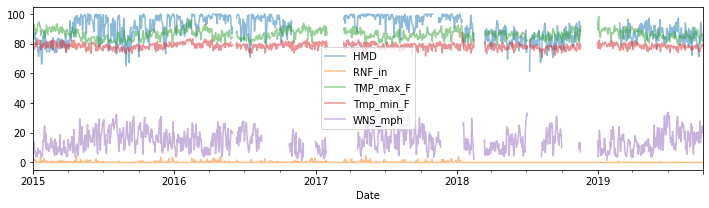

In [23]:
Tula_data.plot(alpha=.5, figsize = (12,3))
Tula_data

# Processing historical ASCC data obtained from Mark

In [0]:
path_ASCC_data_old =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'GroWeatherData 2004-2014.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_old), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 8, 12, 14, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
numcols = ['Air Temp', 'Solar Rad', 'Wind Speed', 'Rain', 'Hum']
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 
ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling

ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together


# remove trash
ASCC_All_daily[ASCC_All_daily < 0] = np.nan
ASCC_All_daily = ASCC_All_daily.loc[:"2013-12-31"]     # remove trashy data at the end of the stations life

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_old = ASCC_All_daily


############  New station   ##################
# read in data from the new weather station.
path_ASCC_data_new =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'ASCCWeatherData_2015-2018_direct.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_new), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 5, 7, 8, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
ASCC_All = ASCC_All.rename(columns={'OutTemp':'Air Temp', 'HumOut':'Hum', 'SpeedWind':'Wind Speed', 'Rad.Solar':'Solar Rad'})
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 

ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling


ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_new = ASCC_All_daily

# merge old and new
ASCC_All_combined = pd.concat([ASCC_All_daily_old, ASCC_All_daily_new])

In [0]:
del ASCC_All_combined['TMP_ave']
del ASCC_All_combined['Solar Rad']

,Wind Speed,Hum,Rain,Tmp_max,Tmp_min
Date_Time,,,,,
2004-08-26,1.123871,91.739130,0.000000,74.12,73.94
2004-08-27,3.194235,81.326389,0.031496,81.86,73.76
2004-08-28,2.914322,76.980296,0.000000,82.22,74.12
2004-08-29,2.312018,76.781250,0.000000,82.58,73.04
2004-08-30,2.455063,82.052083,0.110236,83.84,73.40
...,...,...,...,...,...
2018-02-18,0.020712,7.916667,0.015748,86.90,76.46
2018-02-19,0.020712,13.656250,0.015748,87.26,76.10
2018-02-20,0.000000,12.208333,0.000000,87.44,76.28


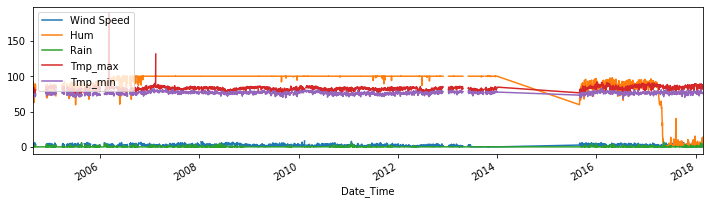

In [26]:
#fig, ax, = plt.subplots()
ASCC_All_combined.plot(figsize =(12,3))
ASCC_All_combined

# Start the big fill 

### Fill in Tula dataset 

working on filling HMD
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 12)                24        
_________________________________________________________________
dense_78 (Dense)             (None, 80)                1040      
_________________________________________________________________
dense_79 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6915921582313647; acc of 0.0%
working on filling Tmp_min_F
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param 

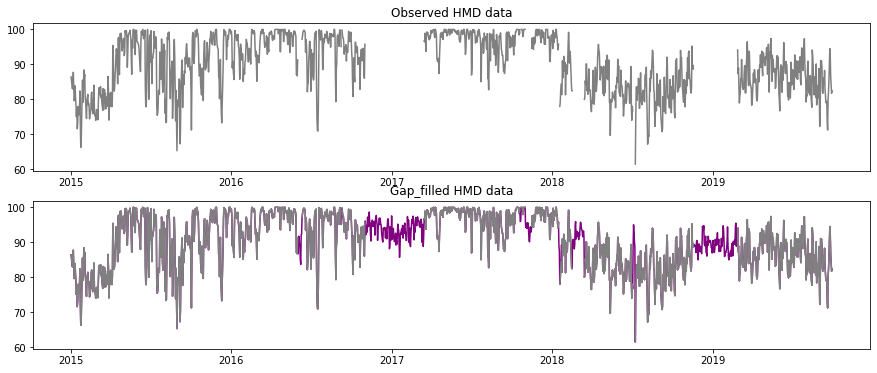

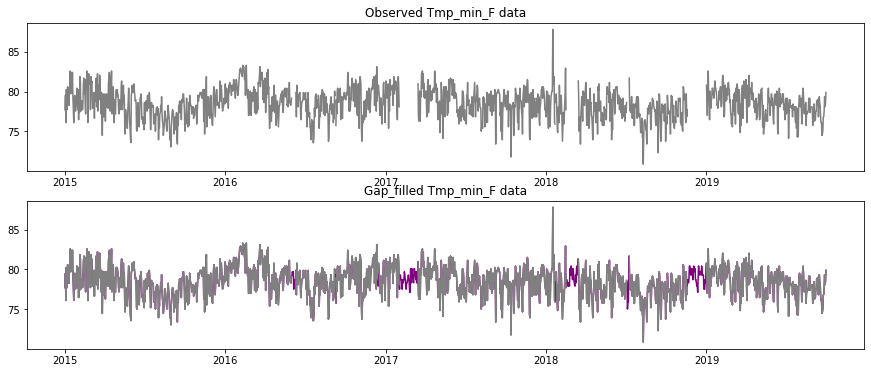

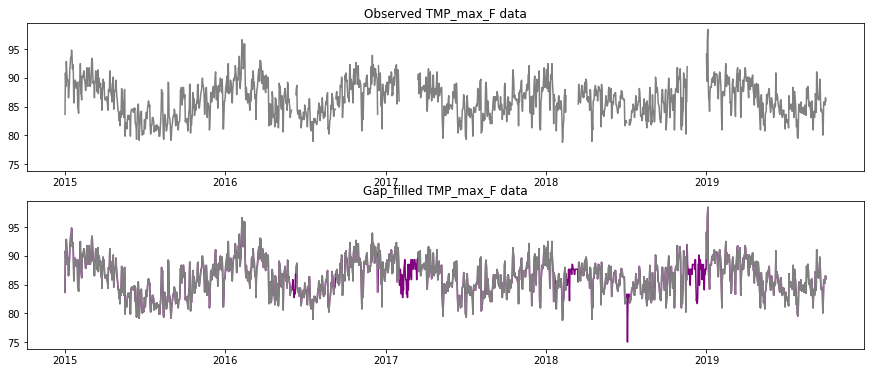

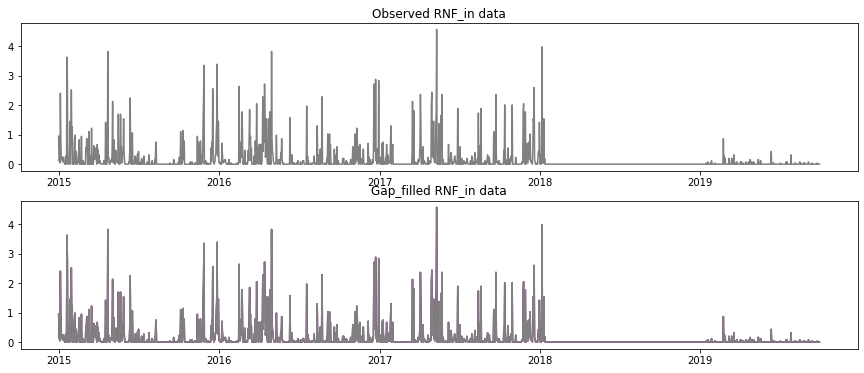

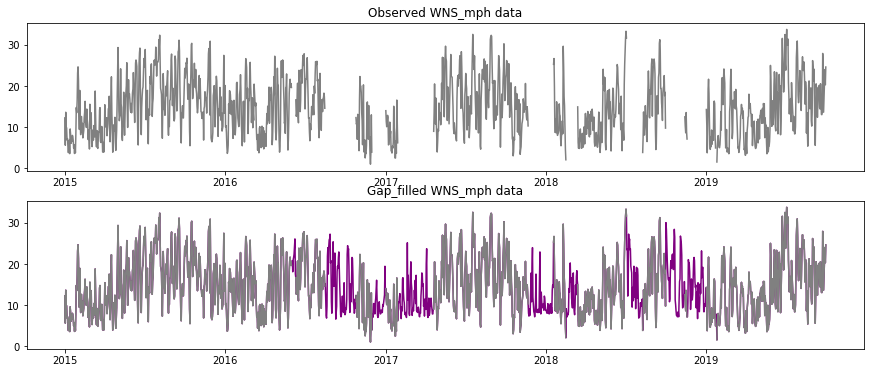

In [55]:

Magic_Tula_data = Tula_data.copy()   # the end result container

Tula_cols = ['HMD',           'Tmp_min_F', 'TMP_max_F', 'RNF_in', 'WNS_mph']
PPG_cols  = ['RH_pct_filled', 'TMIN',    'TMAX',    'PRCP',   'AWND_filled']

# model checkpoint params  
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')
keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.01),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

for idx, tcol in enumerate(Tula_cols):
    print("working on filling {}".format(tcol))
    ppgcol = PPG_cols[idx]
    Tula_temp_frame = Tula_data[[tcol]]
    PPG_tempframe   = magic_data[[ppgcol]]

    # join the two colummns of same variable from different stations
    data = pd.merge(PPG_tempframe, Tula_temp_frame, how='inner', left_index=True, right_index=True)   # careful with the behavior of inner, seems to leave gaps with nan values but starts the frame where both datasets exist  which is what I want
    train_data = data.dropna()       # remove any rows where there is no data (a gap) 

    # define and scale each dataset
    X_train = train_data[ppgcol].values 
    X_train = X_train.reshape(-1, 1)
    X_train_scaler = StandardScaler().fit(X_train)
    X_train = X_train_scaler.transform(X_train)

    y_train = train_data[tcol].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    y_train_scaler = StandardScaler().fit(y_train)
    y_train = y_train_scaler.transform(y_train)

    #set up the network a-fresh
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, 1, activation, optimizer)    # input shape of 1 since only training on one columns

    # train the network
    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_split = .5, callbacks=keras_callbacks)

    ## load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


    # now that we have the trained model, use it to predict parameter of interest. 
    X_fill = data[ppgcol].values 
    X_fill = X_fill.reshape(-1, 1)
    XScaler_dic[tcol] = StandardScaler().fit(X_fill)
    X_fill =  XScaler_dic[tcol].transform(X_fill)                       # scale existing data in other columns  
    y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
    y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)         # rescale the data back to its real magnitudes

    generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
    generated_dataframe['real_data'] = data[tcol]

    # if the real series has a gap fill with generated data, if not use real data
    generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
        lambda row: row['gendata'] if np.isnan(row['real_data']) else row['real_data'], axis=1)   

    # merge it in to the big dataset
    Magic_Tula_data['Magic_{}'.format(tcol)] = generated_dataframe['Magic_{}'.format(tcol)]
    
    # plot results
    fig, ax = plt.subplots(2, 1, figsize=(15, 6))
    ax[0].plot(Magic_Tula_data[tcol], color = 'grey')
    ax[0].set_title('Observed {} data'.format(tcol))
    ax[1].plot(Magic_Tula_data['Magic_{}'.format(tcol)], color = 'purple')
    ax[1].plot(Magic_Tula_data[tcol], color = 'grey')
    ax[1].set_title('Gap_filled {} data'.format(tcol))

In [31]:
Magic_Tula_data

,HMD,RNF_in,TMP_max_F,Tmp_min_F,WNS_mph,Magic_HMD,Magic_Tmp_min_F,Magic_TMP_max_F,Magic_RNF_in,Magic_WNS_mph
Date,,,,,,,,,,
2015-01-01,86.416667,0.944882,83.66,77.72,12.275208,86.416667,77.72,83.66,0.944882,12.275208
2015-01-02,85.166667,0.118110,90.86,79.52,5.638953,85.166667,79.52,90.86,0.118110,5.638953
2015-01-03,84.000000,0.157480,88.52,76.10,13.645334,84.000000,76.10,88.52,0.157480,13.645334
2015-01-04,83.000000,0.039370,92.84,80.24,9.954383,83.000000,80.24,92.84,0.039370,9.954383
2015-01-05,84.666667,2.401576,91.40,78.62,9.861177,84.666667,78.62,91.40,2.401576,9.861177
...,...,...,...,...,...,...,...,...,...,...
2019-09-26,92.125000,0.000000,85.82,77.54,17.159194,92.125000,77.54,85.82,0.000000,17.159194
2019-09-27,86.375000,0.000000,85.46,79.34,20.906068,86.375000,79.34,85.46,0.000000,20.906068
2019-09-28,84.166667,0.000000,85.28,78.08,23.991182,84.166667,78.08,85.28,0.000000,23.991182


<IPython.core.display.Javascript object>


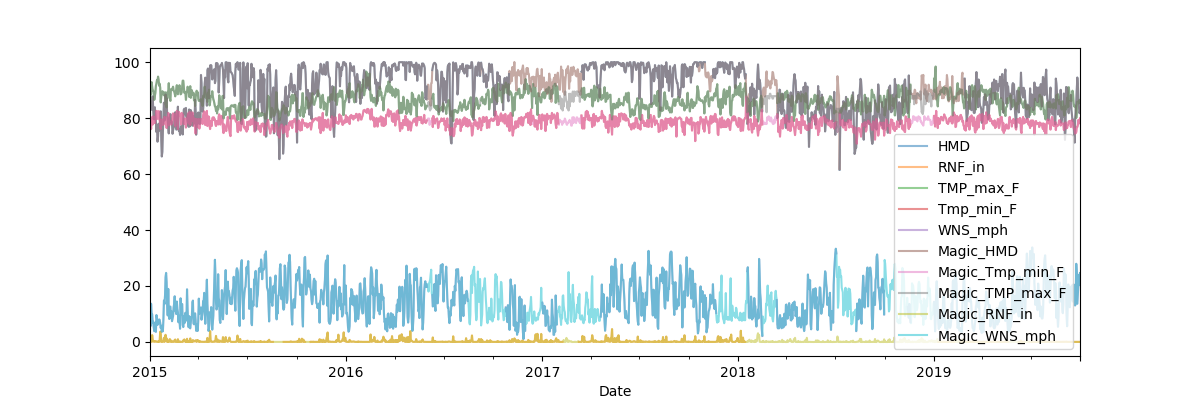

In [0]:
Magic_Tula_data.plot(figsize = (12,4), alpha =.5)

In [0]:
Magic_Tula_data

,HMD,RNF_in,TMP_max_F,Tmp_min_F,WNS_mph,Magic_HMD,Magic_Tmp_min_F,Magic_TMP_max_F,Magic_RNF_in,Magic_WNS_mph
Date,,,,,,,,,,
2015-01-01,86.416667,0.944882,83.66,77.72,12.275208,86.416667,77.72,83.66,0.944882,12.275208
2015-01-02,85.166667,0.118110,90.86,79.52,5.638953,85.166667,79.52,90.86,0.118110,5.638953
2015-01-03,84.000000,0.157480,88.52,76.10,13.645334,84.000000,76.10,88.52,0.157480,13.645334
2015-01-04,83.000000,0.039370,92.84,80.24,9.954383,83.000000,80.24,92.84,0.039370,9.954383
2015-01-05,84.666667,2.401576,91.40,78.62,9.861177,84.666667,78.62,91.40,2.401576,9.861177
...,...,...,...,...,...,...,...,...,...,...
2019-09-26,92.125000,0.000000,85.82,77.54,17.159194,92.125000,77.54,85.82,0.000000,17.159194
2019-09-27,86.375000,0.000000,85.46,79.34,20.906068,86.375000,79.34,85.46,0.000000,20.906068
2019-09-28,84.166667,0.000000,85.28,78.08,23.991182,84.166667,78.08,85.28,0.000000,23.991182


In [0]:
ASCC_All_combined.columns

Index(['Wind Speed', 'Hum', 'Rain', 'Tmp_max', 'Tmp_min'], dtype='object')

working on filling Hum
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_424 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_425 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_426 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_427 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 1.0791583080750762; acc of 0.0%


<IPython.core.display.Javascript object>


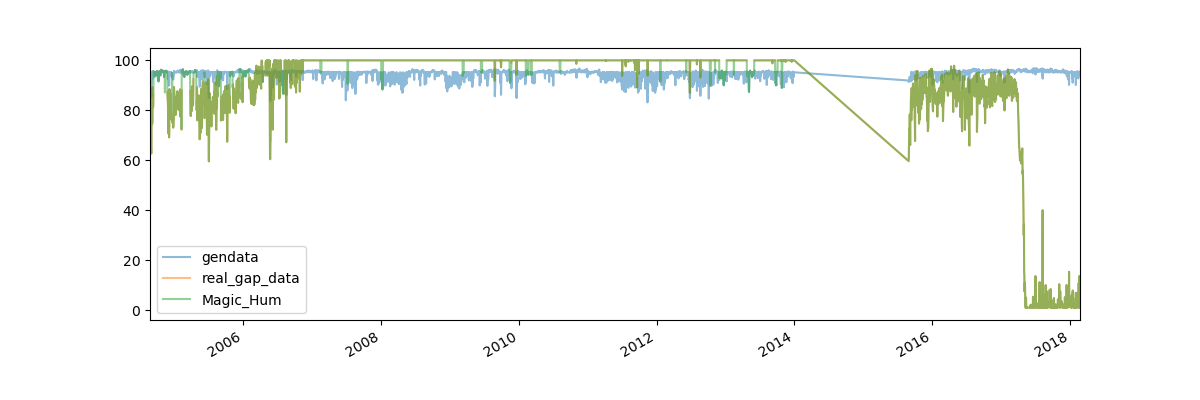

working on filling Tmp_min
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_428 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_429 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_430 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_431 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.5299471543775096; acc of 0.0%


<IPython.core.display.Javascript object>


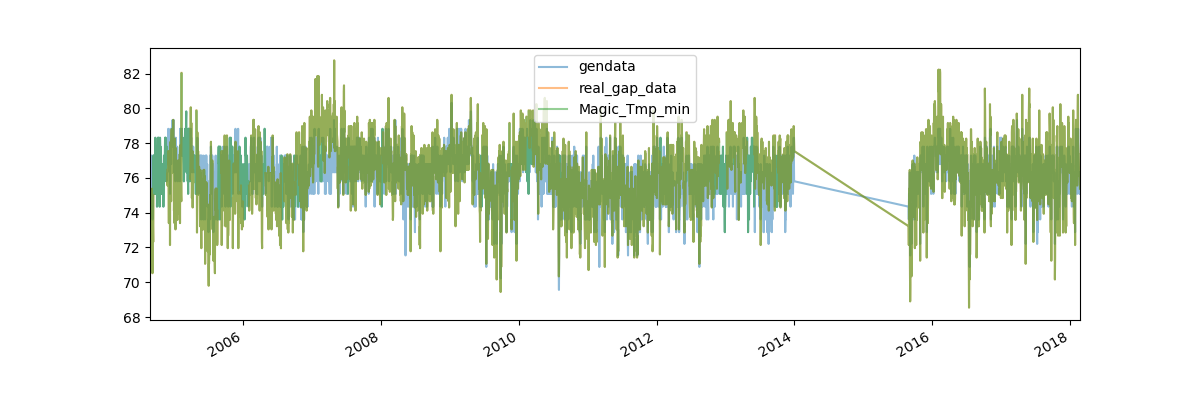

working on filling Tmp_max
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_432 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_433 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_434 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_435 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6801416992958057; acc of 0.0%


<IPython.core.display.Javascript object>


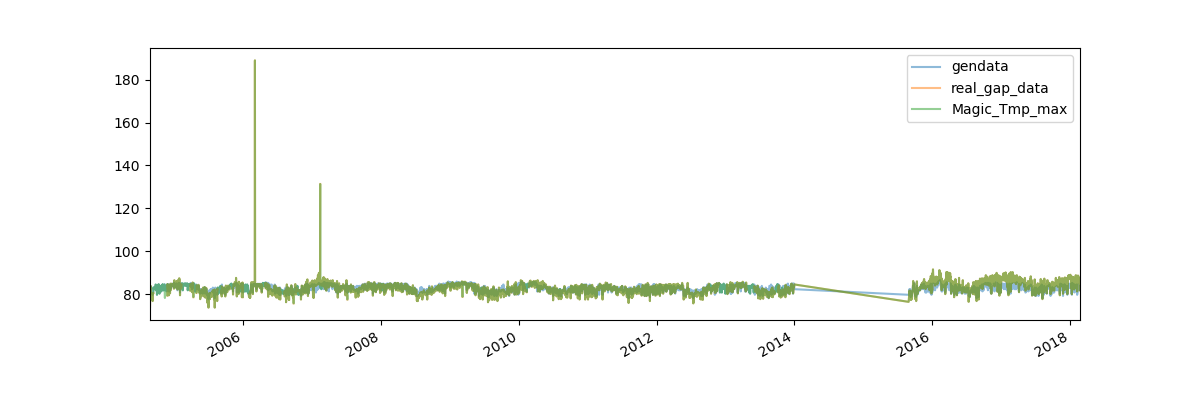

working on filling Rain
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_436 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_437 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_438 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_439 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.7059611765242196; acc of 0.0%


<IPython.core.display.Javascript object>


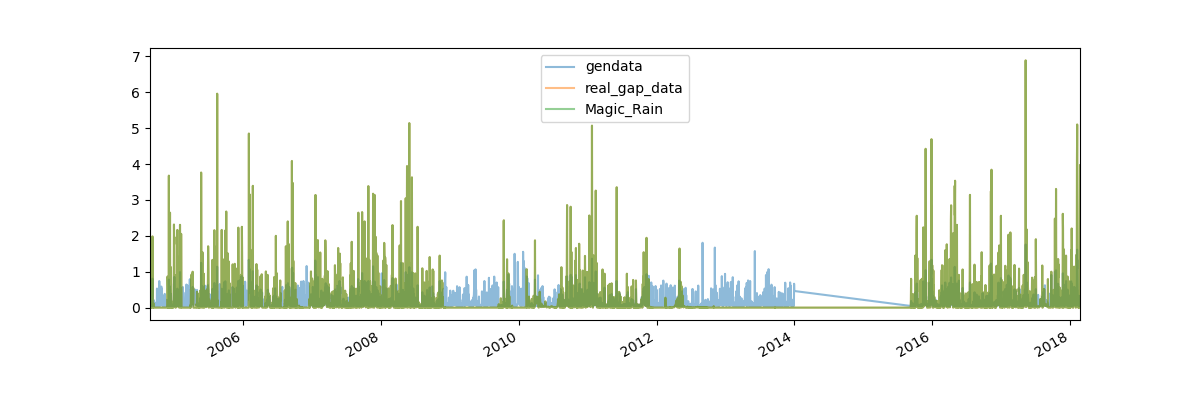

working on filling Wind Speed
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_440 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_441 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_442 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_443 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6056530447538486; acc of 0.0%


<IPython.core.display.Javascript object>


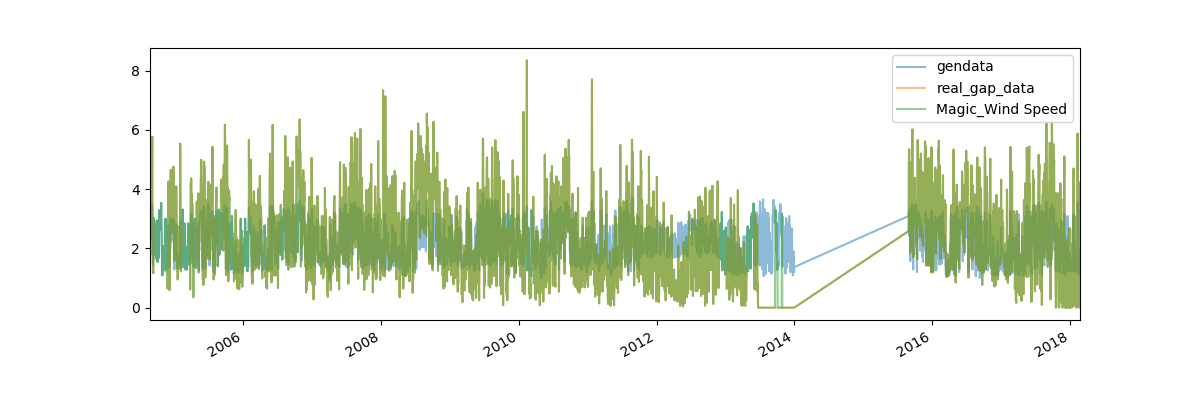

In [0]:
Magic_ASCC_data = ASCC_All_combined.copy()   # the end result container

ASCC_cols = ['Hum',           'Tmp_min', 'Tmp_max', 'Rain', 'Wind Speed']
PPG_cols  = ['RH_pct_filled', 'TMIN',    'TMAX',    'PRCP',   'AWND_filled']

# model checkpoint params  
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')
keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.01),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

for idx, tcol in enumerate(ASCC_cols):
    print("working on filling {}".format(tcol))
    ppgcol = PPG_cols[idx]
    ASCC_temp_frame = ASCC_All_combined[[tcol]].copy()
    PPG_tempframe   = magic_data[[ppgcol]]

    # join the two colummns of same variable from different stations
    data = pd.merge(PPG_tempframe, ASCC_temp_frame, how='inner', left_index=True, right_index=True)   # careful with the behavior of inner, seems to leave gaps with nan values but starts the frame where both datasets exist  which is what I want
    train_data = data.dropna()       # remove any rows where there is no data (a gap) 

    # define and scale each dataset
    X_train = train_data[ppgcol].values 
    X_train = X_train.reshape(-1, 1)
    X_train_scaler = StandardScaler().fit(X_train)
    X_train = X_train_scaler.transform(X_train)

    y_train = train_data[tcol].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    y_train_scaler = StandardScaler().fit(y_train)
    y_train = y_train_scaler.transform(y_train)

    #set up the network a-fresh
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, 1, activation, optimizer)    # input shape of 1 since only training on one columns

    # train the network
    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_split = .5, callbacks=keras_callbacks)

    ## load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    # now that we have the trained model, use it to predict parameter of interest. 
    X_fill = data[ppgcol].values 
    X_fill = X_fill.reshape(-1, 1)
    XScaler_dic[tcol] = StandardScaler().fit(X_fill)
    X_fill =  XScaler_dic[tcol].transform(X_fill)                       # scale existing data in other columns  
    y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
    y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)         # rescale the data back to its real magnitudes

    generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
    generated_dataframe['real_gap_data'] = data[tcol]

    # if the real series has a gap fill with generated data, if not use real data
    generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
        lambda row: row['gendata'] if np.isnan(row['real_gap_data']) else row['real_gap_data'], axis=1)   

    # merge it in to the big dataset
    Magic_ASCC_data['Magic_{}'.format(tcol)] = generated_dataframe['Magic_{}'.format(tcol)]
    
    generated_dataframe.plot(figsize = (12,4), alpha=.5)

In [0]:
Probably useless, looking at CNNs   https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf